関数の微分をSympyで自動生成する。(手計算でもできるが)

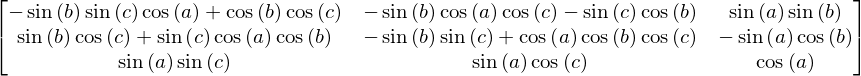

In [27]:
#回転行列と、その角度微分をSympyで生成する     
from sympy import *

# おまじない
init_printing()

# theta, phi, psi
a,b,c=symbols('a b c')
# Goldstein 
# 回転の順序は、
# 1. 分子のz軸周りにpsi (c)回す。
# 2. 分子のz軸をx軸周りにtheta (a)倒す。
# 3. 倒れた分子をz軸周りにphi (b)回す。
# AIはこれらの逆手順になっている?
# 直線分子はz軸に沿うように配置すると、1のz軸周りの回転が不要になり、phiが消える。
# また、z軸周りの慣性モーメントが0となる。

B = Matrix([[ cos(c),sin(c),0],
            [-sin(c), cos(c),0],
            [0,0,1]])
C = Matrix([[1,0,0],
            [0, cos(a),sin(a)],
            [0,-sin(a), cos(a)]])
D = Matrix([[ cos(b),sin(b),0],
            [-sin(b), cos(b),0],
            [0,0,1]])
# Goldstein 4-47
# 剛体座標から空間座標へ変換する行列
AI = (B*C*D).T


# 解析的に回転行列を角度で微分し、それをpythonの関数とする。
A = lambdify([a,b,c],AI)
Aa = lambdify([a,b,c],diff(AI,a))
Ab = lambdify([a,b,c],diff(AI,b))
Ac = lambdify([a,b,c],diff(AI,c))
Aaa = lambdify([a,b,c],diff(AI,a,a))
Abb = lambdify([a,b,c],diff(AI,b,b))
Acc = lambdify([a,b,c],diff(AI,c,c))
Aab = lambdify([a,b,c],diff(AI,a,b))
Abc = lambdify([a,b,c],diff(AI,b,c))
Aca = lambdify([a,b,c],diff(AI,c,a))
AI

## 相互作用

In [3]:
# 相互作用関数の距離での微分はsympyで自動生成する。

a1,a2,r = symbols('a1 a2 r')
F = 1/r
phic=lambdify([r], F)
phic_r=lambdify([r], diff(F,r))
phic_rr=lambdify([r], diff(F,r,r))
F = a1*r**(-12) - a2*r**(-6)
phiLJ=lambdify([r,a1,a2], F)
phiLJ_r=lambdify([r,a1,a2], diff(F,r))
phiLJ_rr=lambdify([r,a1,a2], diff(F,r,r))

## 切断関数

相互作用は無限遠まで計算するのではなく、どこかで打ち切る。打ち切る距離のすこし手前から、スムーズに0に収束させるために、切断関数(Truncation function)をかける。

Truncation functionは、Site-site間ではなく重心間の距離の関数なので、切断関数を重心間距離やEuler角で微分するのは容易。ただし、相互作用関数にこれをかけた上で、微分すると、いろんな微分の組み合わせが発生して、かなり面倒な式になる。


In [25]:
#rout = 8.5
#trans = 2.0
#rin  = rout - trans

x, y, rin, trans = symbols('x y rin trans')
# F0 is a truncation function ranged in [0,1]
F0 = -(x-1)**3*(6*x**2+3*x+1)
# 関数区間を変更
F = F0.subs(x,(y-rin)/trans)
# 解析的な微分を、数値関数に変換する

# Truncation function, raw
Trunc = lambdify([y, rin, trans], F.simplify())

# Truncation function, first derivative
Trunc_r = lambdify([y, rin, trans], diff(F,y).simplify())

# Truncation function, second derivative
Trunc_rr = lambdify([y, rin, trans], diff(F,y,y).simplify())

# Trunc(6.5), Trunc(8.5), Trunc_r(6.5), Trunc_r(8.5), Trunc_rr(6.5), Trunc_rr(8.5)
?Trunc_rr

Signature: Trunc_rr(y, rin, trans)
Docstring:
Created with lambdify. Signature:

func(y, rin, trans)

Expression:

6*(rin + trans - y)*(trans**2 + 3*trans*(-rin + y) + 6*(rin - y)**2 -...

Source code:

def _lambdifygenerated(y, rin, trans):
    return (6*(rin + trans - y)*(trans**2 + 3*trans*(-rin + y) + 6*(rin - y)**2 - 3*(-4*rin + trans + 4*y)*(rin + trans - y) + 2*(rin + trans - y)**2)/trans**5)


Imported modules:
File:      /Volumes/Shared/GoogleDrive/gitwork3/nma/<lambdifygenerated-62>
Type:      function


* Pohorille, A., Pratt, L. R., LaViolette, R. A., Wilson, M. A. & MacElroy, R. D. Comparison of the structure of harmonic aqueous glasses and liquid water. *J. Chem. Phys.* **87**, 6070–6077 (1998).

## Kinetic energy tensor
$$\mathbf{K}=\left(\begin{array}{ccc}I_1\cos^2\psi+I_2\sin^2\psi&(I_1-I_2)\sin\theta\sin\psi\cos\psi&0\\\ &(I_1\sin^2\psi+I_2\cos^2\psi)\sin^2\theta+I_3\cos^2\theta&I_3\cos\theta\\\ &&I_3\end{array}\right)$$
これを対角化したものを$\mathbf{K}_\mathrm{D}$と書き、対角化に使った固有ベクトルの行列を$\mathbf{S}$と書く。
$$\mathbf{S}^{-1}\mathbf{K}\mathbf{S}=\mathbf{K}_\mathrm{D}$$
求めたいものは、
$$\mathbf{K}_\mathrm{D}^{-1/2}\mathbf{S}^T\mathbf{V}\mathbf{S}\mathbf{K}_\mathrm{D}^{-1/2}$$
の固有値である(らしい)。$\mathbf{V}$は力の定数の行列。

対角化されているので、$\mathbf{K}_\mathrm{D}^{-1/2}$は対角項をそれぞれ$-(1/2)$乗するだけでいい。

直線分子の場合は、$I_3=0$かつ$I_1=I_2$なので、おそらく
$$\mathbf{K}=\left(\begin{array}{cc}I&0\\\ &I\sin^2\theta\end{array}\right)$$
となる?とすれば、Kはもともと対角化されているのでSは単位行列となる。(本当か?)

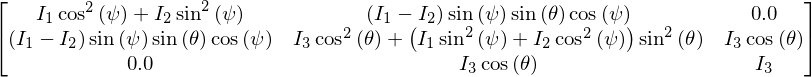

In [5]:
theta, psi, I1, I2, I3 = symbols("theta psi I_1, I_2, I_3")
ket = Matrix(3,3, [I1*cos(psi)**2 + I2*sin(psi)**2, (I1-I2)*sin(theta)*sin(psi)*cos(psi), 0.0,
                   (I1-I2)*sin(theta)*sin(psi)*cos(psi),  (I1*sin(psi)**2+I2*cos(psi)**2)*sin(theta)**2+I3*cos(theta)**2, I3*cos(theta),
                   0.0,  I3*cos(theta), I3])
ket

In [12]:
KETensor = lambdify([theta,psi,I1,I2,I3], ket)
?KETensor

Signature: KETensor(theta, psi, I_1, I_2, I_3)
Docstring:
Created with lambdify. Signature:

func(theta, psi, I_1, I_2, I_3)

Expression:

Matrix([[I_1*cos(psi)**2 + I_2*sin(psi)**2, (I_1 -...

Source code:

def _lambdifygenerated(theta, psi, I_1, I_2, I_3):
    return (array([[I_1*cos(psi)**2 + I_2*sin(psi)**2, (I_1 - I_2)*sin(psi)*sin(theta)*cos(psi), 0.0], [(I_1 - I_2)*sin(psi)*sin(theta)*cos(psi), I_3*cos(theta)**2 + (I_1*sin(psi)**2 + I_2*cos(psi)**2)*sin(theta)**2, I_3*cos(theta)], [0.0, I_3*cos(theta), I_3]]))


Imported modules:
File:      /Volumes/Shared/GoogleDrive/gitwork3/nma/<lambdifygenerated-26>
Type:      function


In [26]:
#!jupyter nbconvert --to script Symbolic.ipynb

[NbConvertApp] Converting notebook Symbolic.ipynb to script
[NbConvertApp] Writing 3849 bytes to Symbolic.py
